In [3]:
## import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn


In [6]:
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

train_path = "CASIA_faceAntisp/train_release"
test_path = "../../AntiSpoofing/CASIA_faceAntisp/test_release"

dim = 128

In [4]:
class CNN(nn.Module):
  def __init__(self , num_classes=10):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=2) ,
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) ,
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.layer3 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3) ,
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.layer4 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=11, stride=1, padding=5) ,
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.fc = nn.Linear(8192 , num_classes)
    
  def forward(self , x):
    # print("Entro layer 1")
    out = self.layer1(x)
    # print("Layer 1 Shape: ", out.shape)
    out = self.layer2(out)
    # print("Layer 2 Shape: ", out.shape)
    # print("Paso layer 2")
    out = self.layer3(out)
    # print("Layer 3 Shape: ", out.shape)
    # print("Paso layer 3")
    out = self.layer4(out)
    # print("Layer 4 Shape: ", out.shape)
    # print("Paso layer 4")
    out = out.reshape(out.size(0) , -1)
    # print("Reshape Shape: ", out.shape)
    # print("Reshapeo")
    out = self.fc(out)
    # print("FC Shape: ", out.shape)
    return out

In [10]:
def get_training_subject(path, samples_per_video):
    real_videos = ['1.avi', '2.avi', 'HR_1.avi', 'HR_4.avi']
    subject = []
    target = []
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    for dir in os.listdir(os.path.join(path)):
        cap = cv2.VideoCapture(os.path.join(path, dir))
        resampling_rate = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / samples_per_video)
        count = 0
        failed = False
        while cap.isOpened():
            success, img = cap.read()
            if success and (failed or (count%resampling_rate == 0)):
                faces = face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1.1, 4)
                if len(faces) != 1:
                    failed = True
                    continue
                (x, y, w, h) = faces[0]
                subject.append(torch.Tensor(cv2.resize(img[y:y+h,x:x+w], dsize=(dim,dim))))
                target.append(1 if dir in real_videos else 0)
                failed = False
            else:
                break
            count += 1
    return subject, target

def read_training_files(path, samples_per_video=16):
    features = []
    targets = []
    for person in tqdm(os.listdir(path)):
        f, t = get_training_subject(os.path.join(path,person), samples_per_video)
        features += f
        targets += t
    return features, targets

In [6]:
train_features, train_targets = read_training_files(train_path, samples_per_video=16)

100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


In [11]:
test_features, test_targets = read_training_files(test_path, samples_per_video=16)

100%|██████████| 30/30 [03:56<00:00,  7.88s/it]


In [7]:
train_features = torch.stack(train_features)
train_features = train_features.permute(0, 3, 1, 2)


In [8]:
train_features.shape

torch.Size([240, 3, 128, 128])

In [9]:
train_targets = torch.Tensor(train_targets)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [11]:
num_classes = 2
learning_rate = 0.001
num_epochs = 20


In [12]:
def train(model, optimizer, loss_fn, num_epochs):
  # train the model
  list_loss= []
  avg_list_loss = []

  for epoch in range(num_epochs):
    images = train_features.to(device)
    labels = train_targets.type(torch.LongTensor).to(device)
    output = model(images)
    # print(output)
    loss   = loss_fn(output, labels)
    # change the params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    list_loss.append(loss.item())
            
    print ('Epoch [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, num_epochs, loss.item()))

    avg_list_loss.append(np.mean(list_loss))

    list_loss = []
    
  print('Finished Training Trainset')
  return avg_list_loss


In [13]:
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
avg_list_loss = train(model, optimizer, loss_fn, 100)


Epoch [1/100], Loss: 0.8388
Epoch [2/100], Loss: 5.2006
Epoch [3/100], Loss: 1.2402
Epoch [4/100], Loss: 0.9675
Epoch [5/100], Loss: 0.7529
Epoch [6/100], Loss: 0.7825
Epoch [7/100], Loss: 0.7412
Epoch [8/100], Loss: 0.6092
Epoch [9/100], Loss: 0.5641
Epoch [10/100], Loss: 0.5776
Epoch [11/100], Loss: 0.5712
Epoch [12/100], Loss: 0.5468
Epoch [13/100], Loss: 0.5138
Epoch [14/100], Loss: 0.4821
Epoch [15/100], Loss: 0.4590
Epoch [16/100], Loss: 0.4604
Epoch [17/100], Loss: 0.4744
Epoch [18/100], Loss: 0.4625
Epoch [19/100], Loss: 0.4305
Epoch [20/100], Loss: 0.4189
Epoch [21/100], Loss: 0.4245
Epoch [22/100], Loss: 0.4197
Epoch [23/100], Loss: 0.4104
Epoch [24/100], Loss: 0.4010
Epoch [25/100], Loss: 0.3912
Epoch [26/100], Loss: 0.3809
Epoch [27/100], Loss: 0.3744
Epoch [28/100], Loss: 0.3705
Epoch [29/100], Loss: 0.3643
Epoch [30/100], Loss: 0.3554
Epoch [31/100], Loss: 0.3462
Epoch [32/100], Loss: 0.3395
Epoch [33/100], Loss: 0.3341
Epoch [34/100], Loss: 0.3268
Epoch [35/100], Loss: 0

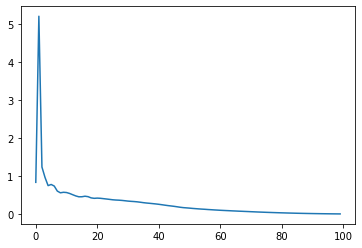

In [15]:
#plot the loss
plt.plot(avg_list_loss)